In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.ndimage import gaussian_filter
import tqdm
from joblib import Parallel, delayed
from markov_functions import *
from itertools import product
import warnings
import ast
from scipy.optimize import curve_fit

In [2]:
def plot_sequence(sequence_parent, sequence_to_find, freq, ax, average_color='magenta', sequence_color='C1'):
    
    shorten_type = {
        'fastball': 'F',
        'offspeed': 'O',
        'breaking': 'B'
    }
    
    target_sequence = sequence_parent[sequence_parent['sequence_tuple'] == sequence_to_find]
    
    num_pitches = len(sequence_to_find)
    all_x_coords = [[] for _ in range(num_pitches)]
    all_y_coords = [[] for _ in range(num_pitches)]


    for idx, row in target_sequence.iterrows():
        coord_sequence = ast.literal_eval(row['pitch_coord_sequence'])
        
        x_seq = [coord[0] for coord in coord_sequence]
        y_seq = [coord[1] for coord in coord_sequence]
        
        # Store coordinates for average calculation
        for i in range(num_pitches):
            all_x_coords[i].append(x_seq[i])
            all_y_coords[i].append(y_seq[i])
            
        # Plot individual sequence
        ax.plot(x_seq, y_seq, marker='o', linestyle='-', alpha=0.2, color=sequence_color)

    # Calculate the average and standard deviation for each pitch
    avg_x = np.mean(all_x_coords, axis=1)
    avg_y = np.mean(all_y_coords, axis=1)
    std_x = np.std(all_x_coords, axis=1)
    std_y = np.std(all_y_coords, axis=1)

    # Plot the average sequence with error bars
    ax.errorbar(avg_x, avg_y, xerr=std_x, yerr=std_y, marker='s', linestyle='--', 
                color=average_color, label='Average Sequence', capsize=5, elinewidth=3, markeredgewidth=3)
    ax.scatter(avg_x, avg_y, marker='o', color=average_color, s=300)

    # Add pitch order numbers to the average plot
    for i, (x, y) in enumerate(zip(avg_x, avg_y)):
        ax.text(x , y-1.5 , str(i + 1), color='k', fontsize=15, ha='center', va='bottom', fontweight='bold',
                # bbox=dict(facecolor=None, alpha=0.5, edgecolor='k', boxstyle='round,pad=0.2')
                )
    # Add the strike zone and background to the plot
    plotting_background(ax)

    ax.text(0, 30, ' - '.join([shorten_type[pt] for pt in sequence_to_find]), fontweight='bold', fontsize=16, ha='center')

In [13]:
def model(x, a, b, c, d):
    return a * np.exp(-b * (x-c)) + d

def fit_freq(x, y):
    # Fit the model to the data
    lower_bounds = [0, 0, 0, 0]
    upper_bounds = [np.inf, np.inf, np.inf, np.inf]
    popt, pcov = curve_fit(model, x, y, bounds=(lower_bounds, upper_bounds))

    # Return the optimal parameters
    return popt

Good endings count: 387
Bad endings count: 322
Pitcher: 肯特, Opposite-handed: True


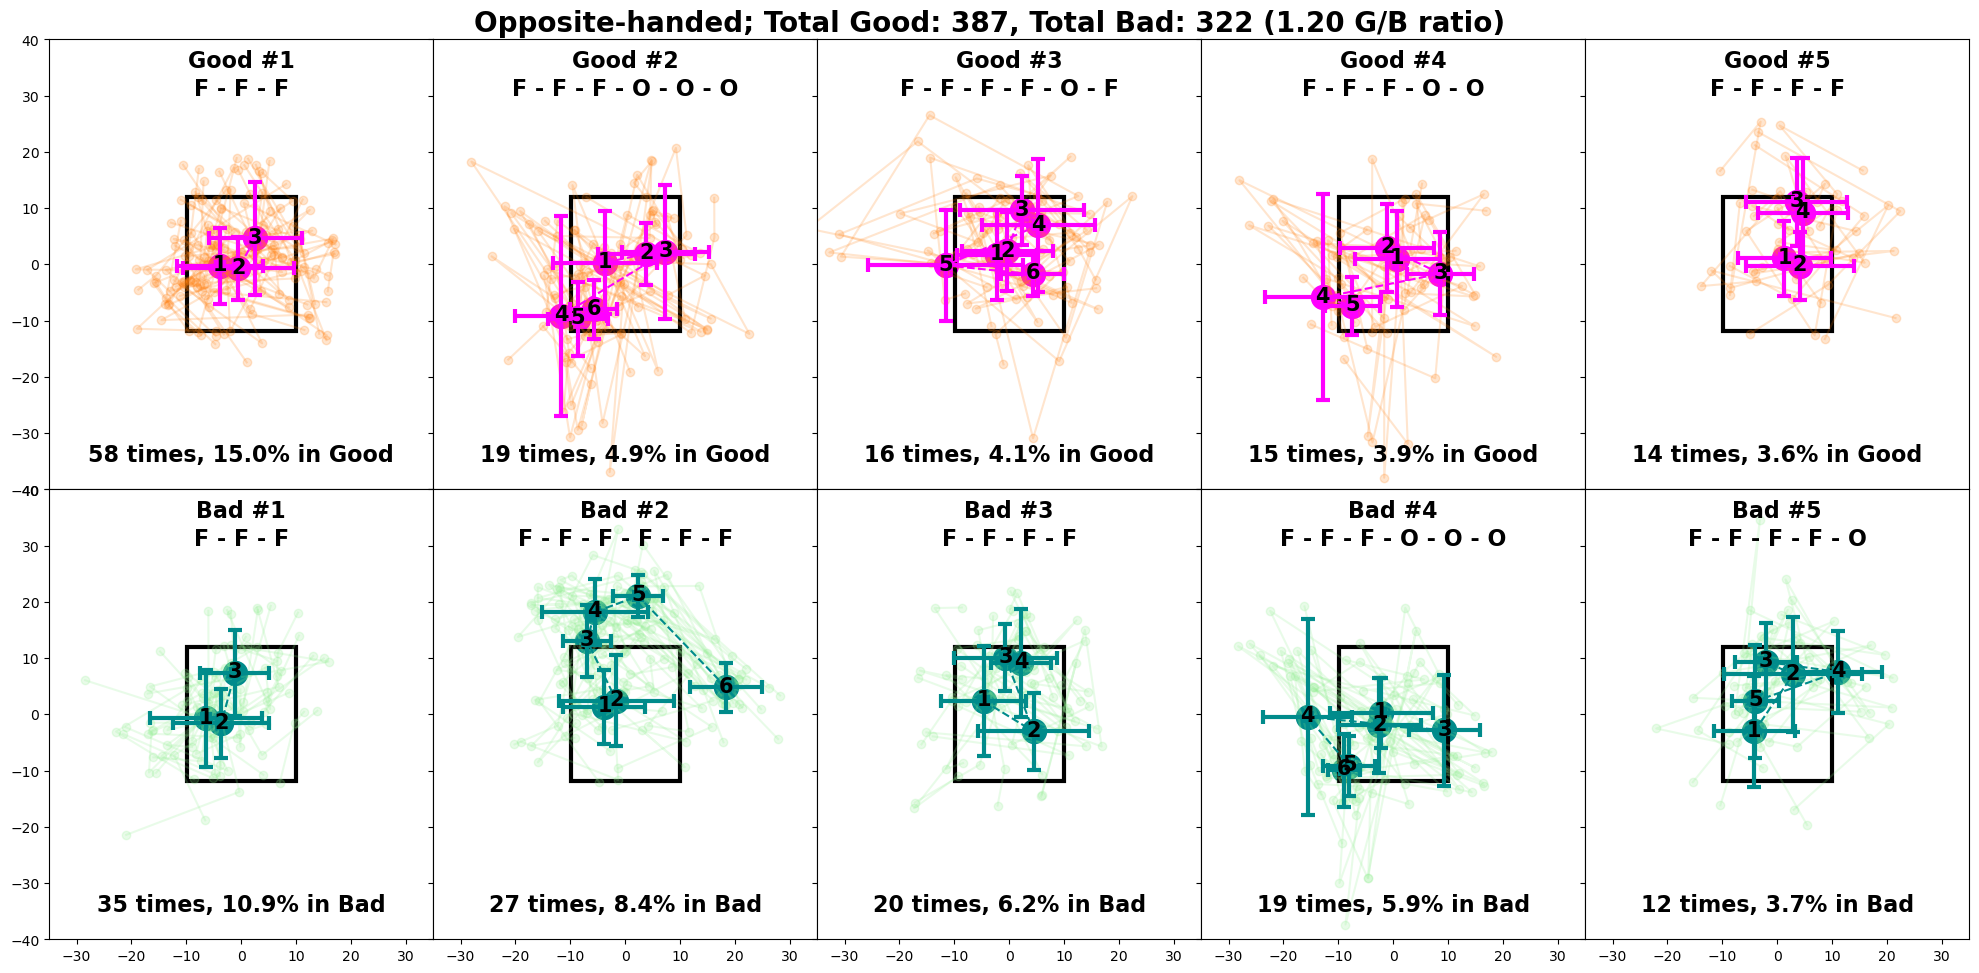

Pitcher: 肯特, Opposite-handed: True
Total sequences ending with a fastball:
185 124
rate: 0.478 vs 0.385
G/B ratio: 1.49
Good endings count: 415
Bad endings count: 251
Pitcher: 肯特, Opposite-handed: False


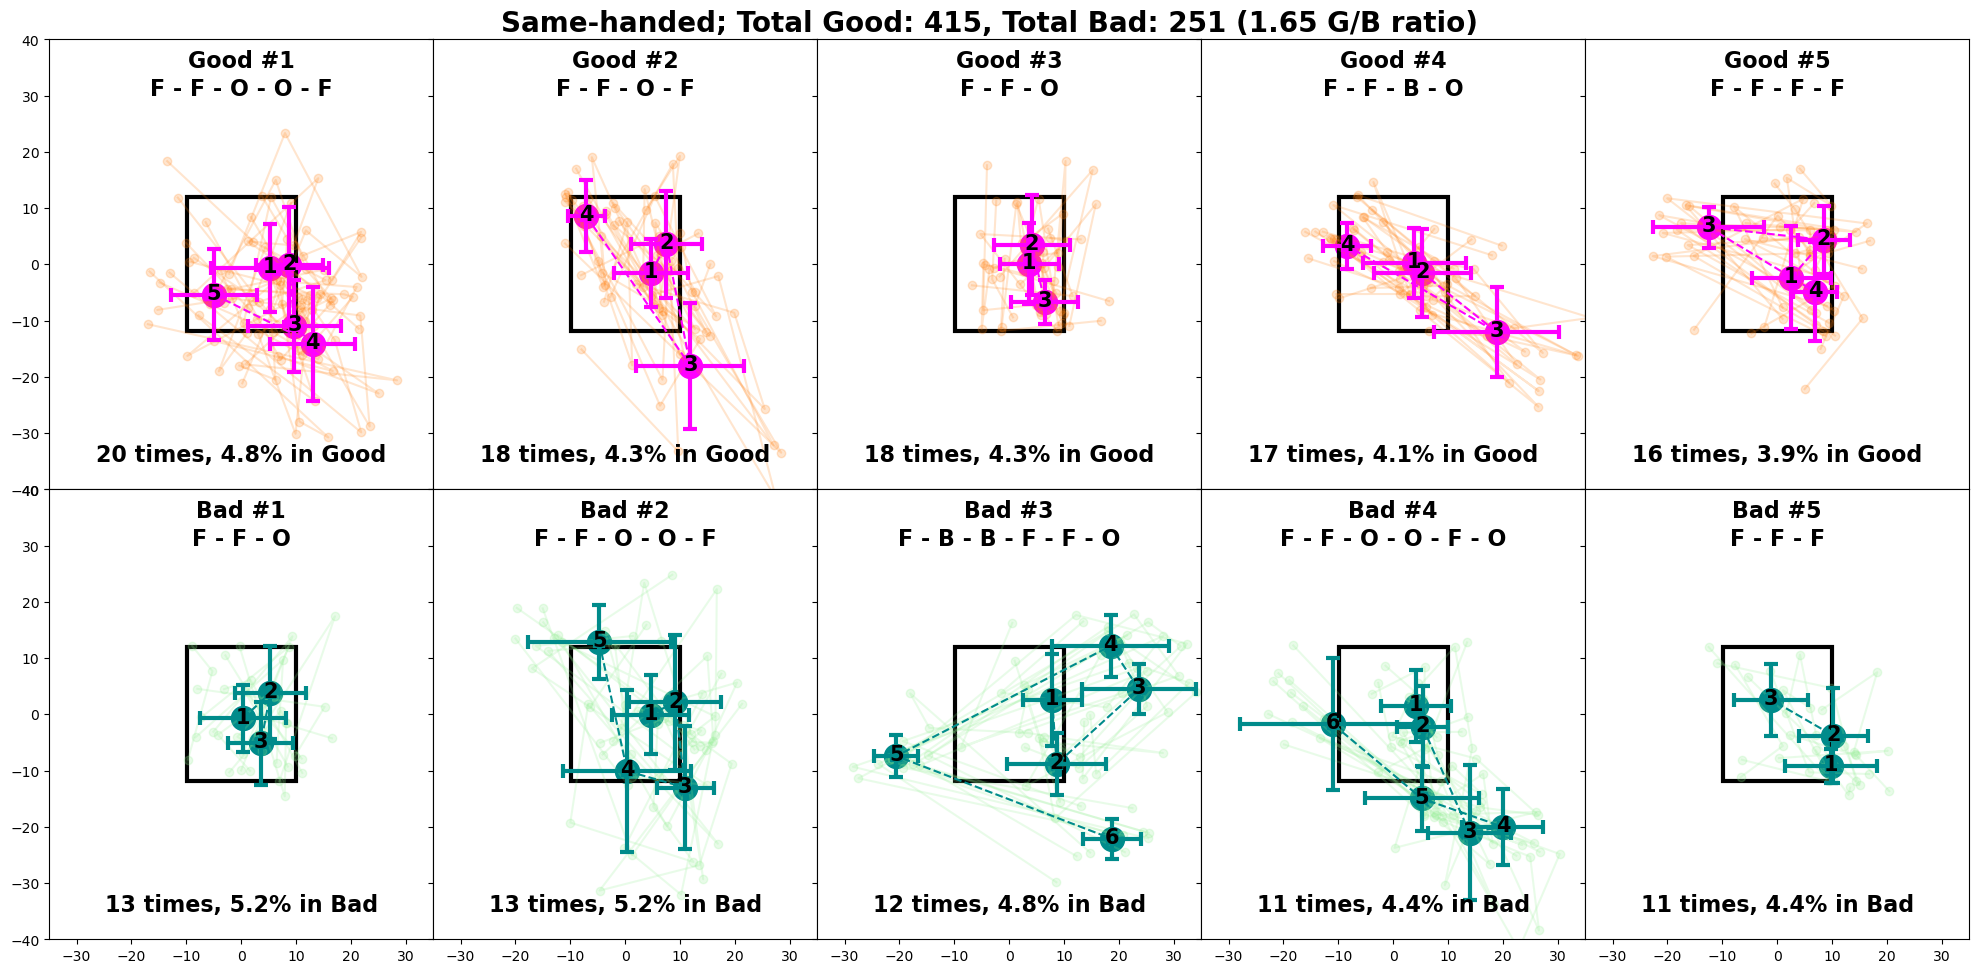

Pitcher: 肯特, Opposite-handed: False
Total sequences ending with a fastball:
164 140
rate: 0.395 vs 0.558
G/B ratio: 1.17


In [48]:
# pitchers_list = ['勝騎士', '古林睿煬', '艾璞樂', '肯特', '威能帝']
pitchers_list = ['肯特']

for pitcher_n in pitchers_list:
    for oppo in [True, False]:
        store_result = f'{pitcher_n}_oppo_{oppo}_new.csv'

        # Load the simulation results
        try:
            results_df = pd.read_csv(store_result)
        except FileNotFoundError:
            print(f"Error: The file '{store_result}' was not found. Please run the simulation cell first.")
            # Create an empty DataFrame to avoid further errors
            results_df = pd.DataFrame(columns=['pitch_types_sequence', 'good_ending'])

        if not results_df.empty:
            # The sequences are stored as strings, so we need to convert them back to lists
            # using ast.literal_eval. This is safer than using eval().
            results_df['pitch_types_sequence'] = results_df['pitch_types_sequence'].apply(ast.literal_eval)

            # Filter for sequences with a minimum length of 3
            min_pitch_len = 3
            filtered_df = results_df[results_df['pitch_types_sequence'].apply(len) >= min_pitch_len].copy()

            # Convert the list of pitch types to a tuple so it can be used for grouping/counting
            # Tuples are hashable, while lists are not.
            filtered_df['sequence_tuple'] = filtered_df['pitch_types_sequence'].apply(tuple)

            # Separate the data into good and bad endings
            good_endings_df = filtered_df[filtered_df['good_ending'] == True]
            bad_endings_df = filtered_df[filtered_df['good_ending'] == False]

            print(f"Good endings count: {len(good_endings_df)}")
            print(f"Bad endings count: {len(bad_endings_df)}")
            
            # Count the occurrences of each sequence for both outcomes
            good_sequence_rank = good_endings_df['sequence_tuple'].value_counts().reset_index()
            good_sequence_rank.columns = ['Pitch Sequence', 'Frequency']

            bad_sequence_rank = bad_endings_df['sequence_tuple'].value_counts().reset_index()
            bad_sequence_rank.columns = ['Pitch Sequence', 'Frequency']

            # print("--- Top 10 Most Frequent Sequences Leading to a GOOD Ending ---")
            # # print(good_sequence_rank.head(10))
            # display(good_sequence_rank.head(10))
            # print("\n" + "="*60 + "\n")
            # print("--- Top 10 Most Frequent Sequences Leading to a BAD Ending ---")
            # # print(bad_sequence_rank.head(10))
            # display(bad_sequence_rank.head(10))
        else:
            print("The results DataFrame is empty. No analysis to perform.")
        
        print(f"Pitcher: {pitcher_n}, Opposite-handed: {oppo}")
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
        plt.subplots_adjust(hspace=0.0, wspace=0.0, top=0.95, bottom=0.05, left=0.03, right=0.99)
        for i in range(5):
            ax = axes[0, i]
            # Define the sequence to find as a tuple
            sequence_to_find = good_sequence_rank['Pitch Sequence'][i]
            frequency = good_sequence_rank['Frequency'][i]
            ax.text(0, 35, f'Good #{i+1}', fontsize=16, ha='center', fontweight='bold')
            plot_sequence(good_endings_df, sequence_to_find, freq=frequency, ax=ax, average_color='magenta', sequence_color='C1')
            ax.set_xlim(-35, 35)
            ax.set_ylim(-40, 40)
            ax.text(0, -35, f'{frequency} times, {frequency/len(good_endings_df)*100:.1f}% in Good', fontsize=16, ha='center', fontweight='bold')
        for i in range(5):
            ax = axes[1, i]
            # Define the sequence to find as a tuple
            sequence_to_find = bad_sequence_rank['Pitch Sequence'][i]
            frequency = bad_sequence_rank['Frequency'][i]
            ax.text(0, 35, f'Bad #{i+1}', fontsize=16, ha='center', fontweight='bold')
            plot_sequence(bad_endings_df, sequence_to_find, freq=frequency, ax=ax, average_color='darkcyan', sequence_color='lightgreen')
            ax.set_xlim(-35, 35)
            ax.set_ylim(-40, 40)
            ax.text(0, -35, f'{frequency} times, {frequency/len(bad_endings_df)*100:.1f}% in Bad', fontsize=16, ha='center', fontweight='bold')
        # plt.tight_layout()
        if oppo:
            plt.suptitle(f'Opposite-handed; Total Good: {len(good_endings_df)}, Total Bad: {len(bad_endings_df)} ({len(good_endings_df) / (len(bad_endings_df)):.2f} G/B ratio)', fontsize=20, fontweight='bold')
        else:
            plt.suptitle(f'Same-handed; Total Good: {len(good_endings_df)}, Total Bad: {len(bad_endings_df)} ({len(good_endings_df) / (len(bad_endings_df)):.2f} G/B ratio)', fontsize=20, fontweight='bold')
        plt.savefig(f'{pitcher_n}_oppo_{oppo}.png')
        plt.show()
        plt.close('all')
        
        print(f"Pitcher: {pitcher_n}, Opposite-handed: {oppo}")
        # Filter for sequences ending with a fastball in good outcomes
        good_ending_with_fastball = good_sequence_rank[good_sequence_rank['Pitch Sequence'].apply(lambda seq: seq[-1] == 'offspeed')]

        # Filter for sequences ending with a fastball in bad outcomes
        bad_ending_with_fastball = bad_sequence_rank[bad_sequence_rank['Pitch Sequence'].apply(lambda seq: seq[-1] == 'offspeed')]

        print("Total sequences ending with a fastball:")
        print(np.sum(good_ending_with_fastball['Frequency']), np.sum(bad_ending_with_fastball['Frequency']))
        print(f'rate: {np.sum(good_ending_with_fastball['Frequency']) / len(good_endings_df):.3f} vs {np.sum(bad_ending_with_fastball['Frequency']) / len(bad_endings_df):.3f}')
        print(f'G/B ratio: { np.sum(good_ending_with_fastball["Frequency"]) / np.sum(bad_ending_with_fastball["Frequency"]):.2f}')
        print('==============================')

        
        # fig, ax = plt.subplots(figsize=(6,4))
        # ax.plot(good_sequence_rank['Frequency'][:10], label='Good Ending', color='magenta')
        # good_params = fit_freq(np.arange(len(good_sequence_rank['Frequency'][:10])), good_sequence_rank['Frequency'][:10])
        # print("Good ending fit parameters:", good_params)
        # ax.plot(np.linspace(0,9,10), model(np.linspace(0,9,10), *good_params), 
        #          linestyle='--', color='magenta', label='Good Ending Fit (b={:.2f})'.format(good_params[1]))
        # ax.plot(bad_sequence_rank['Frequency'][:10], label='Bad Ending', color='darkcyan')
        # bad_params = fit_freq(np.arange(len(bad_sequence_rank['Frequency'][:10])), bad_sequence_rank['Frequency'][:10])
        # print("Bad ending fit parameters:", bad_params)
        # ax.plot(np.linspace(0,9,10), model(np.linspace(0,9,10), *bad_params), 
        #          linestyle='--', color='darkcyan', label='Bad Ending Fit (b={:.2f})'.format(bad_params[1]))
        # ax.set_xlabel('Rank of Sequence')
        # ax.set_ylabel('Frequency')
        # ax.set_title('Frequency of Sequences Ending')
        # ax.legend()
        # plt.savefig(f'{pitcher_n}_oppo_{oppo}_freq_fit.png')
        # plt.show()
